# Wicklow isolates snpgenie analysis

* https://www.microbiologyresearch.org/content/journal/mgen/10.1099/mgen.0.000388?crawler=true

In [1]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
sys.path.append('pathogenie')
from snpgenie import tools, aligners, app, trees, plotting

In [2]:
meta = pd.read_csv('/storage/btbgenie/JoeROIData/Mbovis/sampleInformation_NoAnimalIDs_18-12-19.csv')
meta=meta[meta.County=='Wicklow']

## Run workflow 

In [11]:
reload(app)
reload(tools)
args = {'threads':12, 'outdir': '/storage/btbgenie/wicklow_results', 'labelsep':'_',
        'input':['/storage/btbgenie/JoeROIData/Mbovis/Wicklow/Fastqs_07-01-18/',
                 '/storage/btbgenie/JoeROIData/Mbovis/Wicklow/Fastqs_15-03-19/',
                 '/storage/btbgenie/JoeROIData/Mbovis/Wicklow/Fastqs_09-07-18/'],       
         'reference': None, 'overwrite':False,
         'trim': False,
         'filters' : 'QUAL>=30 && FORMAT/DP>=30 && DP4>=4 && MQ>35',
         'custom_filters': True,
         'mask': app.mbovis_mask,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

/storage/btbgenie/wicklow_results/RAxML_bipartitions.variants



In [7]:
meta
labelmap = dict(zip(meta['SeqID'],meta.Aliquot))
#labelmap

In [ ]:
colors = {'Cow': 'blue', 'Deer': 'black','Badger':'red'}
meta['color'] = meta.Species.apply(lambda x: colors[x],1)
colormap = dict(zip(meta['SeqID'],meta.color))
t,ts = trees.create_tree('/storage/btbgenie/wicklow_results/RAxML_bipartitions.variants', 'ref', labelmap, colormap)
#R = t.get_midpoint_outgroup()
#t.set_outgroup(R)
from ete3 import CircleFace, TreeStyle, NodeStyle, RectFace, TextFace
for i in colors:
    f=ts.legend.add_face(
            TextFace(text=i,fgcolor=colors[i],fsize=10),            
            column=0)

N = t.search_nodes(name="ref")[0]
N.delete()
t.render("%%inline",tree_style=ts,w=400)

## snp distance matrix

In [12]:
sm = pd.read_csv('/storage/btbgenie/wicklow_results/snpdist.csv',index_col=0)
sm=sm.rename(columns=labelmap,index=labelmap)
sm[:3]
#plotting.plot_matrix(sm, cmap='gray',w=8)

,ref,TB14-011594,TB14-013251,TB14-011643,TB14-011662,TB15-002018,182-MBovis,TB14-011957,TB15-002353,TB14-012200,...,TB15-002945,TB15-003292,TB15-002976,TB15-003698,TB15-003560,TB15-004348,TB15-004207,TB15-006110,TB15-005018,TB14-010423
ref,0,262,261,270,265,262,59,268,265,263,...,261,271,261,263,265,266,263,265,266,263
TB14-011594,262,0,19,30,9,20,319,28,23,9,...,9,29,23,23,23,22,9,23,24,25
TB14-013251,261,19,0,27,20,7,318,25,8,18,...,18,20,8,8,8,9,18,8,9,10


## RD analysis

In [50]:
from snpgenie import rdiff
reload(rdiff)
rdiff.create_rd_index()
df = W.fastq_table
res = rdiff.find_regions(df,'/storage/btbgenie/wicklow_rd',threads=12)

Fasta("/home/damien/gitprojects/snpgenie/snpgenie/data/MTB-H37Rv.fa")
124.95052829719926


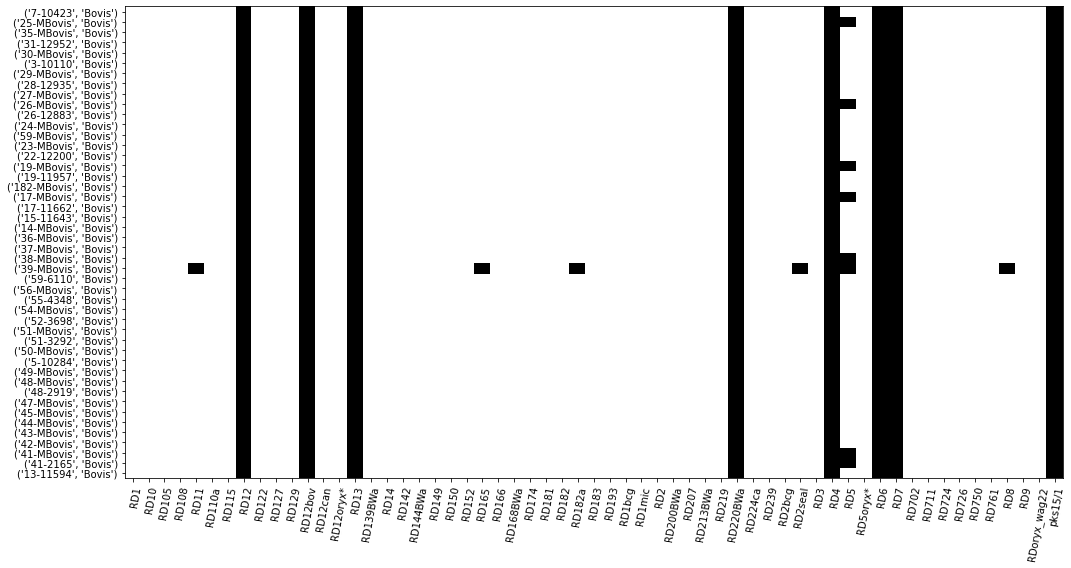

In [136]:
X = rdiff.get_matrix(res, cutoff=0.15)
X['ident'] = X.apply(rdiff.apply_rules,1)
plotting.heatmap(X.set_index('ident',append=True), cmap='cubehelix',h=8)
#plt.savefig('rd_wicklow.png')

## test mapping with fake data

<AxesSubplot:>

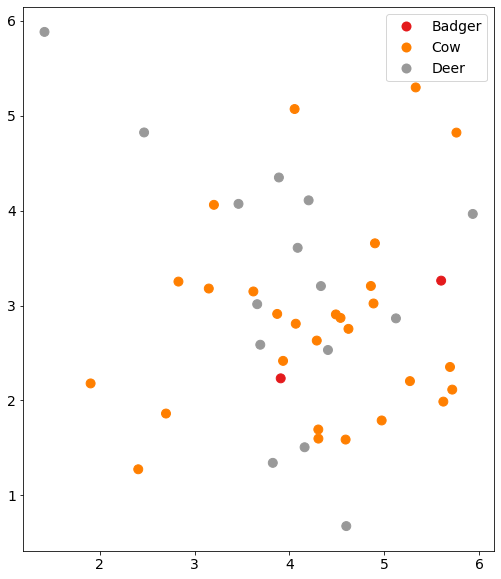

In [13]:
#create dummy locations for isolates

import geopandas as gd
df = meta[['SeqID','Species']].copy()

def get_loc(x):
    long=np.random.normal(4)
    lat=np.random.normal(3)    
    return pd.Series([long, lat], index=['long','lat'])

x = meta.apply(get_loc,1)
df = meta.join(x)
gdf = gd.GeoDataFrame(df, geometry=gd.points_from_xy(df.long, df.lat))
gdf.plot(column='Species',cmap='Set1',s=80,figsize=(10,10), legend=True)
#gdf.head()

# vs JC pipeline results
## Compare sites matrix

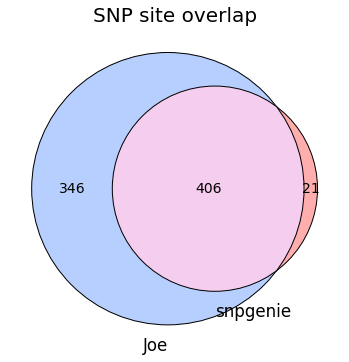

In [12]:
smat = pd.read_csv('/storage/btbgenie/wicklow_results/core.txt',sep=' ',index_col=0)
smat.index
joe_sites = pd.read_csv('/storage/btbgenie/JoeROIData/Mbovis/Wicklow/FASTA/fastaPositions_Prox-10_18-12-2019.txt')
#print (joe_sites)
plt.figure(figsize=(6,6))
import matplotlib_venn
#mpl.rc('text', usetex=True)
mpl.rc('font',size=14)
sets=[set(joe_sites.Position),set(smat.index)]
matplotlib_venn.venn2(sets,set_labels=['Joe','snpgenie'],set_colors=['#4d88ff','#ff3333'])
ax=matplotlib_venn.venn2_circles(sets,linewidth=1)
plt.title('SNP site overlap',fontsize=20)
plt.savefig('snp_overlap_joe.png',dpi=100)

## identify non overlapping sites

In [64]:
df = app.read_csq_file('/storage/btbgenie/wicklow_results/csq.tsv')
x = df.set_index(['start','gene','aa','sample'])['nuc'].unstack('sample')

len(x), len(smat)

(495, 531)

In [58]:
n=list(set(joe_sites.Position) - set(smat.index))
csqmat = pd.read_csv('../test_results/csq.matrix')#.set_index(['gene','aa'])
x[x.start.isin(n)]

sample,start,gene,aa,13-11594,14-MBovis,15-11643,17-11662,17-MBovis,182-MBovis,19-11957,...,50-MBovis,51-3292,51-MBovis,52-3698,54-MBovis,55-4348,56-MBovis,59-6110,59-MBovis,7-10423
0,1057,dnaA,353I>353V,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
14,127447,ctpI,1044L,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
18,159370,fadE1,160F,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
19,160535,fgd2,147K>147E,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
22,166696,BQ2027_MB0144,227H>227R,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,4130927,BQ2027_MB3764,453R,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
477,4162554,BQ2027_MB3805,253A,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
478,4180986,embC,139L,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
489,4311425,eccd2,126G>126D,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [59]:
#frequencies of sites
sitefreqs = (csqmat.sum(1)/len(csqmat.columns)).sort_values(ascending=False)
sitefreqs.value_counts()

0.0625    1798
0.1875     881
0.1250     403
0.7500     153
0.6875      77
0.8750      64
0.2500      36
0.4375      21
0.5000      10
0.6250       6
0.3750       3
0.5625       3
0.3125       2
dtype: int64

In [6]:
#print(W.fastq_table)
meta['name'] = meta.Forward.apply(lambda x: x.split('.')[0])
print(meta.loc[0])
s = pd.merge(W.fastq_table,meta,on='name')
labelmap = dict(zip(s['sample'],s.County))
#print (labelmap)


SeqID                                        1034
Forward           1034_S91_L001-4_R1_001.fastq.gz
Reverse           1034_S91_L001-4_R2_001.fastq.gz
NumberMapped                               902962
MappingProp                              0.999386
SequencingDate                           24-09-19
County                                   Monaghan
VCF                                 1034_1.vcf.gz
Coverage                                 0.900721
AverageDepth                              27.7094
Aliquot                               TB19-001034
Species                                       NaN
Date                                          NaN
name                       1034_S91_L001-4_R1_001
Name: 0, dtype: object


In [ ]:
reload(trees)
t,ts = trees.create_tree('/storage/btbgenie/wicklow_results/RAxML_bipartitions.variants', ref='ref',labelmap=labelmap)
t.render("%%inline",tree_style=ts)

## Compare trees

In [ ]:
reload(trees)
t = trees.create_tree('/storage/btbgenie/JoeROIData/Mbovis/Wicklow/mlTree_WICKLOW_18-12-2019.tree')#, labelmap)
t.render("%%inline")